In [24]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Data Processing
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
import os
os.environ["PATH"] += os.pathsep + 'Users/xxd/anaconda3/lib/python3.9/site-packages/sphinx/templates/graphviz'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# preparing data
from sklearn.decomposition import PCA
from methods import *
from models import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn


model_name = "VAE"
DATASET = 'medical_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = False
REMOVE_NOISE_THRESHOLD = 5
DENOISE = False
NOISE_FACTOR = 0.1
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
NORMALIZATION_SCHEME = 'robust_scaling'
LATENT_DIM = 4
HIDDEN_DIM = 32
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-4
EPOCHS = 10000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'kaiming_normal'
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data1':
    raw_data = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data1':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data = np.concatenate((np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=0)
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data1':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data2':
    raw_data = np.loadtxt('../data/network_flow2_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow2_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]

train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA, normalization_scheme=NORMALIZATION_SCHEME,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, cross_validation=CROSS_VALIDATION_SHUFFLE)
train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
NUM_FEATURE = len(anomalous_data[0])
print(train_data.max())

Train data shape after trim:  (8005, 16)
Train data shape after filter corrcoef:  (8005, 12)
Normalization scheme: standard scaling
Train data shape after normalize:  (8005, 12)
tensor(63.2777)


In [26]:
# use VAE to generate from noise to train
criterion = nn.MSELoss(reduction='sum')
model = AutoEncoder(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
# train
loss_array = train(model, 'SGD', EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e2)
torch.save(model.state_dict(), '../model/param_VAE')

epoch : 1/10000, loss = 31.798337
epoch : 2/10000, loss = 25.006153
epoch : 3/10000, loss = 21.016428
epoch : 4/10000, loss = 17.867022
epoch : 5/10000, loss = 15.516010
epoch : 6/10000, loss = 13.835468
epoch : 7/10000, loss = 12.677241
epoch : 8/10000, loss = 11.662358
epoch : 9/10000, loss = 10.929073
epoch : 10/10000, loss = 10.277781
epoch : 11/10000, loss = 9.748634
epoch : 12/10000, loss = 9.282188
epoch : 13/10000, loss = 8.903408
epoch : 14/10000, loss = 8.565413
epoch : 15/10000, loss = 8.215869
epoch : 16/10000, loss = 7.891788
epoch : 17/10000, loss = 7.574328
epoch : 18/10000, loss = 7.347337
epoch : 19/10000, loss = 7.086162
epoch : 20/10000, loss = 6.910378
epoch : 21/10000, loss = 6.755794
epoch : 22/10000, loss = 6.588680
epoch : 23/10000, loss = 6.450227
epoch : 24/10000, loss = 6.252075
epoch : 25/10000, loss = 6.132606
epoch : 26/10000, loss = 6.000261
epoch : 27/10000, loss = 5.893855
epoch : 28/10000, loss = 5.749338
epoch : 29/10000, loss = 5.649892
epoch : 30/10

In [27]:
# check latent distribution
model.eval()
code, code_attack = model.encoding_layer(train_data), model.encoding_layer(anomalous_data)
mu, var = torch.mean(code, dim=0), torch.std(code, dim=0)
mu_attack, var_attack = torch.mean(code_attack, dim=0), torch.std(code_attack, dim=0)
print(f'Z mean train: {mu}, \nZ sd train: {var}')
print(f'Z mean attack: {mu_attack}, \nZ sd attack: {var_attack}')

Z mean train: tensor([-1.2867, -0.9804,  0.0990, -0.2592], grad_fn=<MeanBackward1>), 
Z sd train: tensor([1.4392, 1.6420, 1.1036, 3.0259], grad_fn=<StdBackward0>)
Z mean attack: tensor([-2.8088,  0.2315,  0.4212, -3.1276], grad_fn=<MeanBackward1>), 
Z sd attack: tensor([14.7911, 15.5926,  4.1062, 13.4942], grad_fn=<StdBackward0>)


In [72]:
model.eval()
generation_size = 200000
random_choices = [-1, 1]

#anomalous_code = model.encode(torch.tensor(anomalous_data).to(torch.float).to(device))
#mu, scale = torch.mean(anomalous_code, dim=0), torch.std(anomalous_code, dim=0, unbiased=True)
#z_p = torch.normal(mu.expand(generation_size, LATENT_DIM), scale.expand(generation_size, LATENT_DIM))
mu, scale = 5, 5
z_p = torch.normal(torch.ones(generation_size, LATENT_DIM)*mu*torch.tensor(np.random.choice(random_choices, size=(generation_size, LATENT_DIM), replace=True)), scale*torch.ones(generation_size, LATENT_DIM))
z_p = z_p.to(torch.float).to(device)
generated_data = model.decode(z_p)
#generated_data = generated_data.detach().numpy()

In [ ]:
#train_data, validation_data, test_data, anomalous_data = model(train_data), model(validation_data), model(test_data), model(anomalous_data)
train_data, validation_data, test_data, anomalous_data = train_data.detach().numpy(), validation_data.detach().numpy(), test_data.detach().numpy(), anomalous_data.detach().numpy()

In [73]:
USE_ATTACK_SAMPLE = False

anomalous_train, anomalous_test = train_test_split(anomalous_data, test_size=0.2)
train_X = np.concatenate((train_data, validation_data, generated_data.detach().numpy()), axis=0)
train_Y = np.concatenate((np.zeros(len(train_data)+len(validation_data)), np.ones(generation_size)))
test_X, test_Y = np.concatenate((test_data, anomalous_test), axis=0), np.concatenate((np.zeros(len(test_data)), np.ones(len(anomalous_test))))

#full_data = np.concatenate((raw_data, anomalous_train), axis=0)
#full_label = np.concatenate((np.zeros(len(raw_data)), np.ones(len(anomalous_train))), axis=0)
if USE_ATTACK_SAMPLE:
    sample_size = 100
    attack_sample_X, attack_sample_Y = anomalous_train[np.random.choice(np.arange(len(anomalous_train)), sample_size, replace=False)], np.ones(sample_size)
    
    train_data1, validation_data1 = train_data[:], validation_data[:]
    for _ in range(1):
        train_data1, validation_data1 = np.concatenate((train_data1, train_data), axis=0), np.concatenate((validation_data1, validation_data), axis=0)
    
    X_res, Y_res = SVMSMOTE().fit_resample(np.concatenate((train_data1, validation_data1, attack_sample_X), axis=0), np.concatenate((np.zeros(len(train_data1)+len(validation_data1)), attack_sample_Y), axis=0))
    print('Data augmentation complete.')
    idc = Y_res == 1
    X_res, Y_res = X_res[idc], Y_res[idc]
    print(f'X_res size:{X_res.shape}')
    train_X, train_Y = np.concatenate((train_X, X_res), axis=0), np.concatenate((train_Y, Y_res), axis=0)
else:
    test_X, test_Y = np.concatenate((test_data, anomalous_data), axis=0), np.concatenate((np.zeros(len(test_data)), np.ones(len(anomalous_data))))
#X_res, Y_res = SVMSMOTE().fit_resample(train_X, train_Y)

#normal_idc = Y_res == 0
#normal_res, anomalous_res = X_res[normal_idc], X_res[np.logical_not(normal_idc)]

rf = RandomForestClassifier(class_weight='balanced')
#rf = RandomForestClassifier()
#rf.fit(X_res, Y_res)
rf.fit(train_X, train_Y)

RandomForestClassifier(class_weight='balanced')

In [75]:
y_pred = rf.predict(test_X)
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1 = precision_score(test_Y, y_pred), recall_score(test_Y, y_pred), f1_score(test_Y, y_pred)

print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")

Accuracy:  0.7592788971367974
Precision: 0.99457111834962
Recall: 0.447702834799609
F1 score: 0.6174587125042129


['SpO2' 'Pulse_Rate' 'SYS' 'DIA' 'Heart_rate' 'Resp_Rate' 'ST']


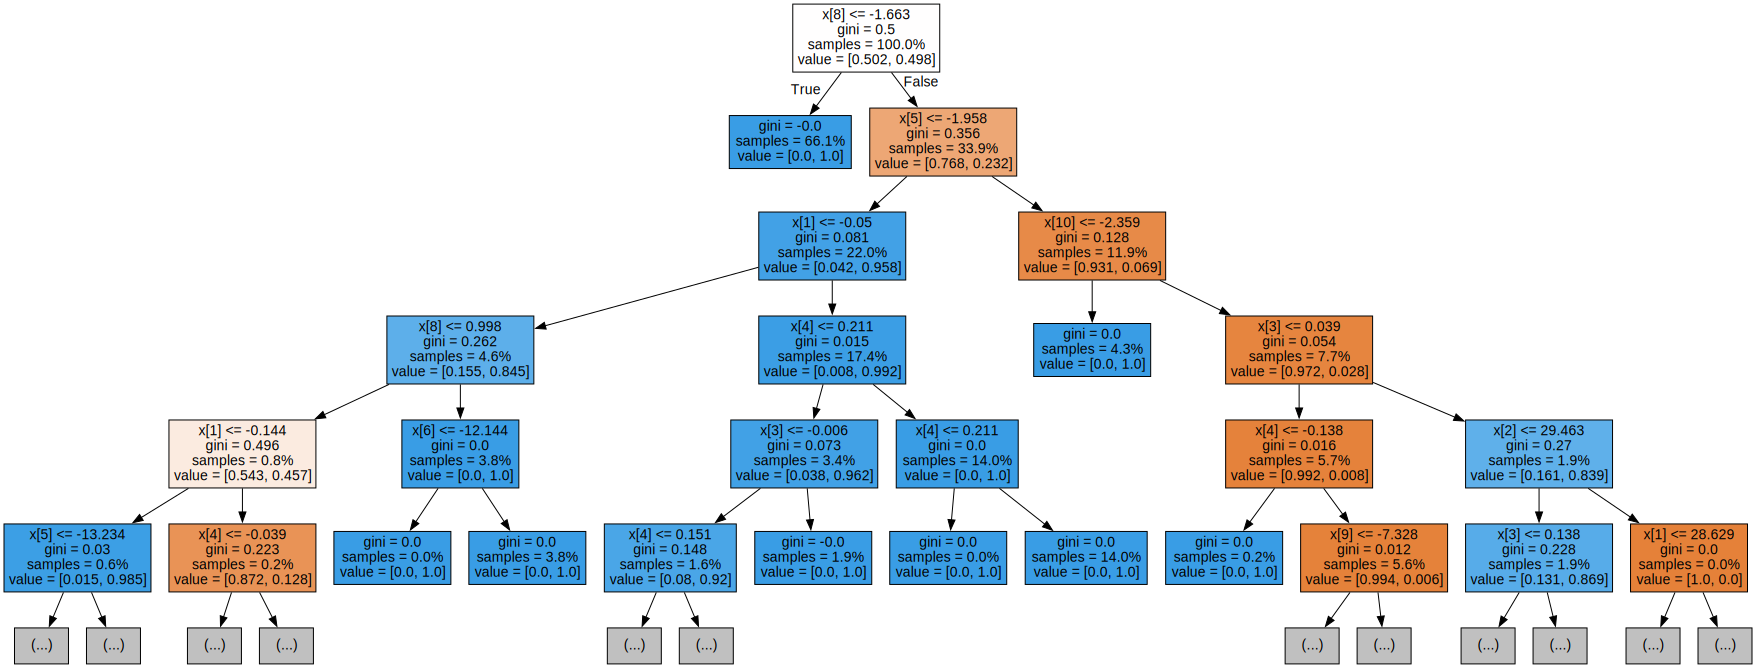

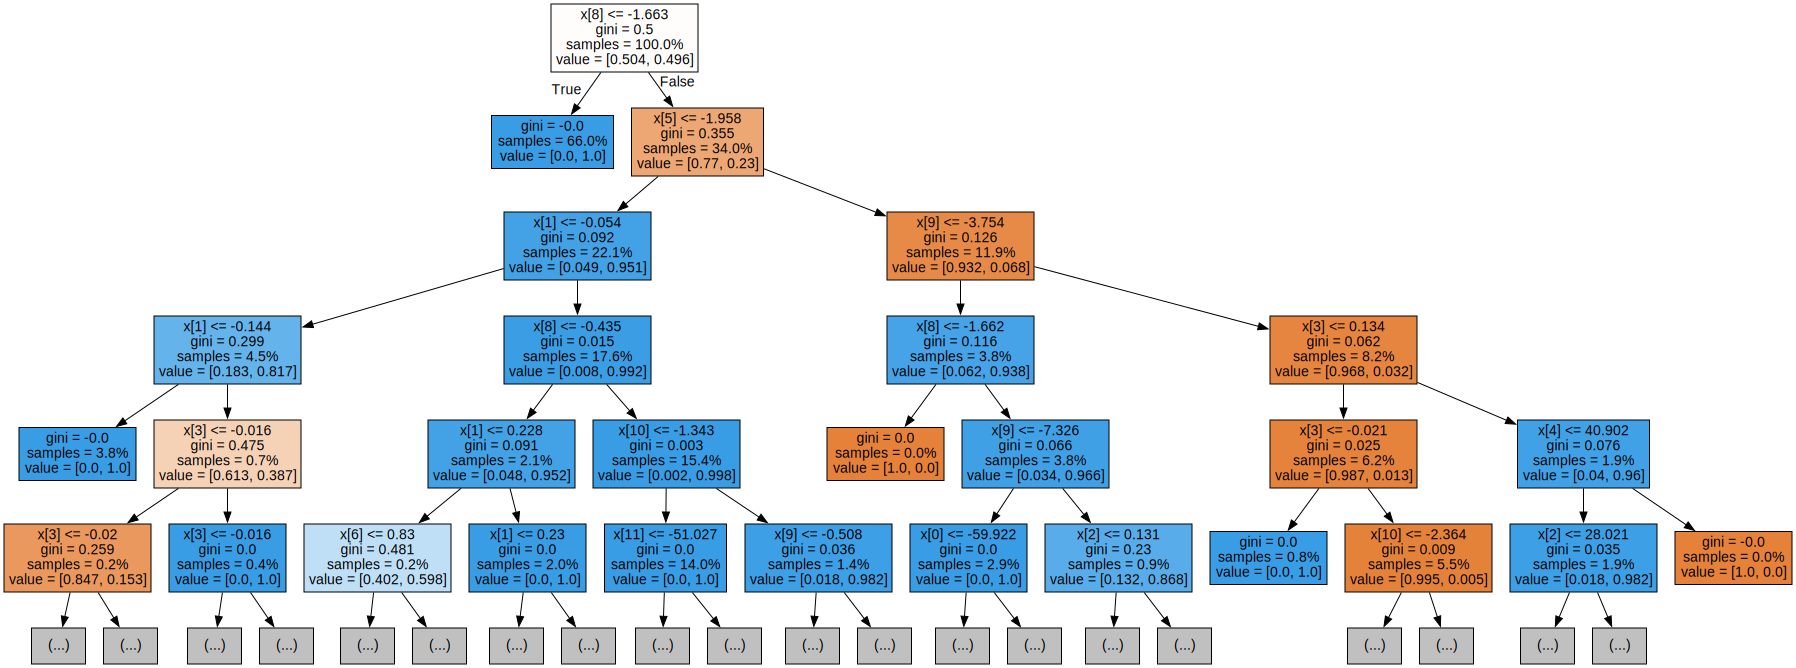

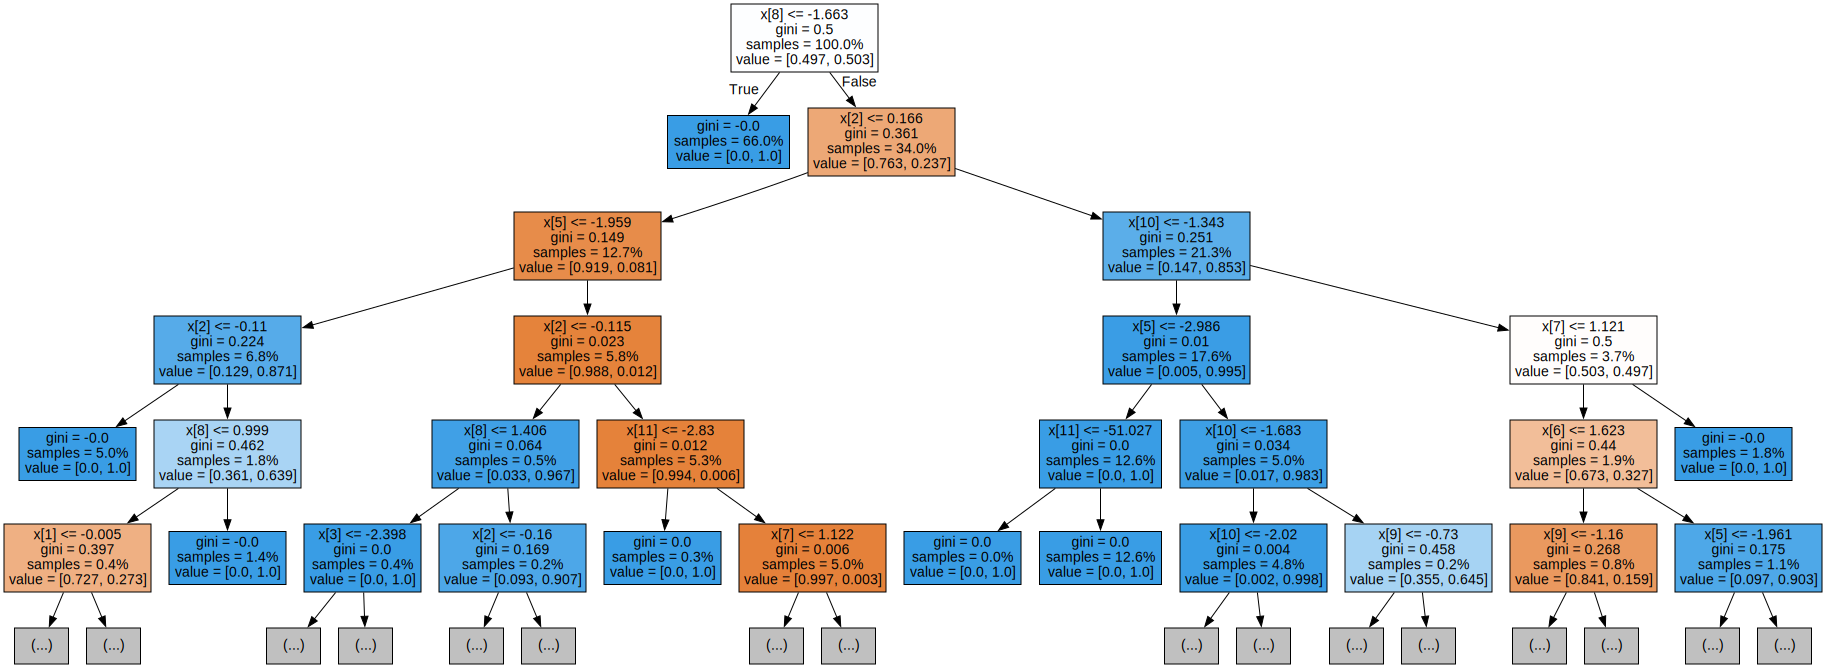

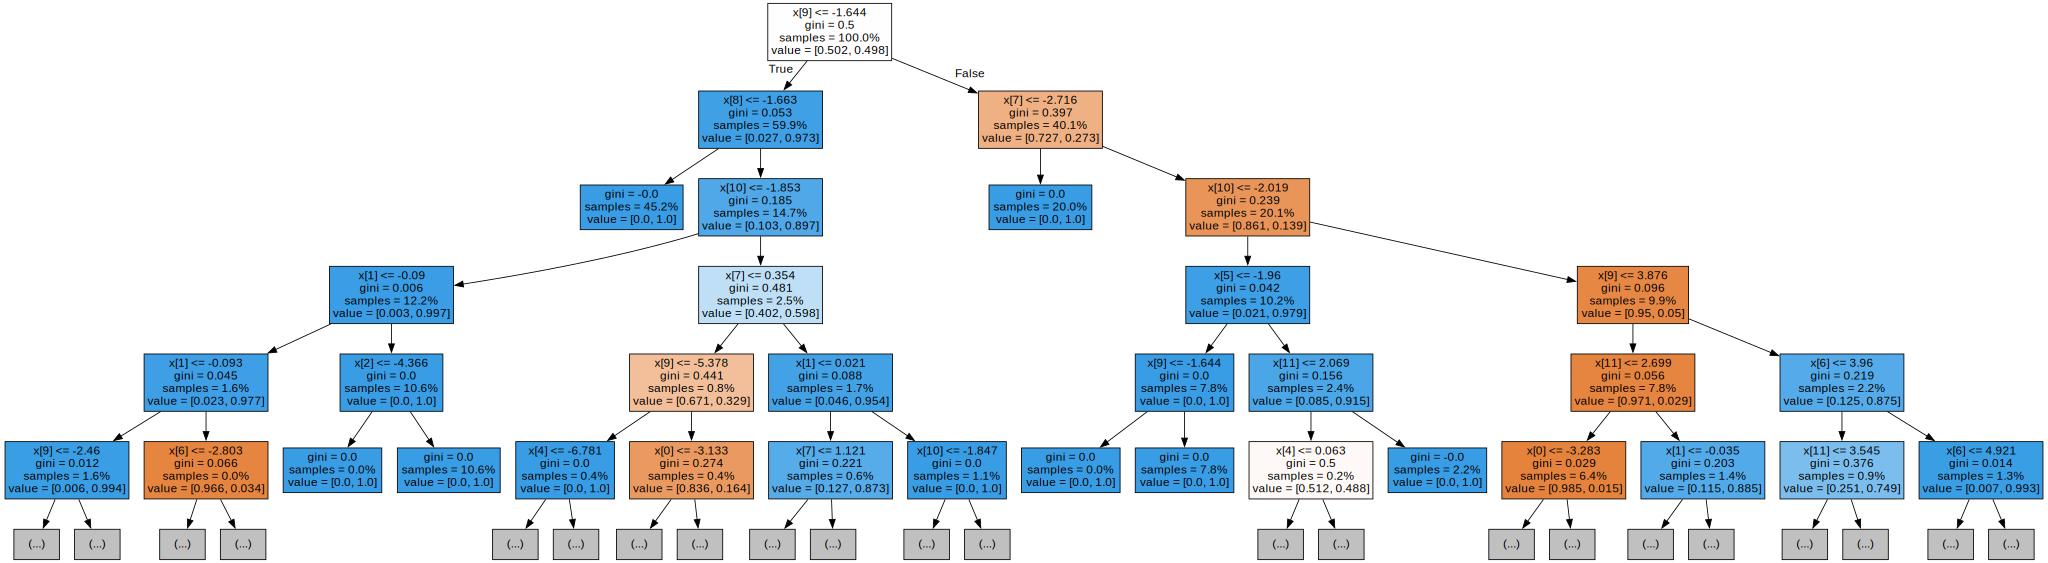

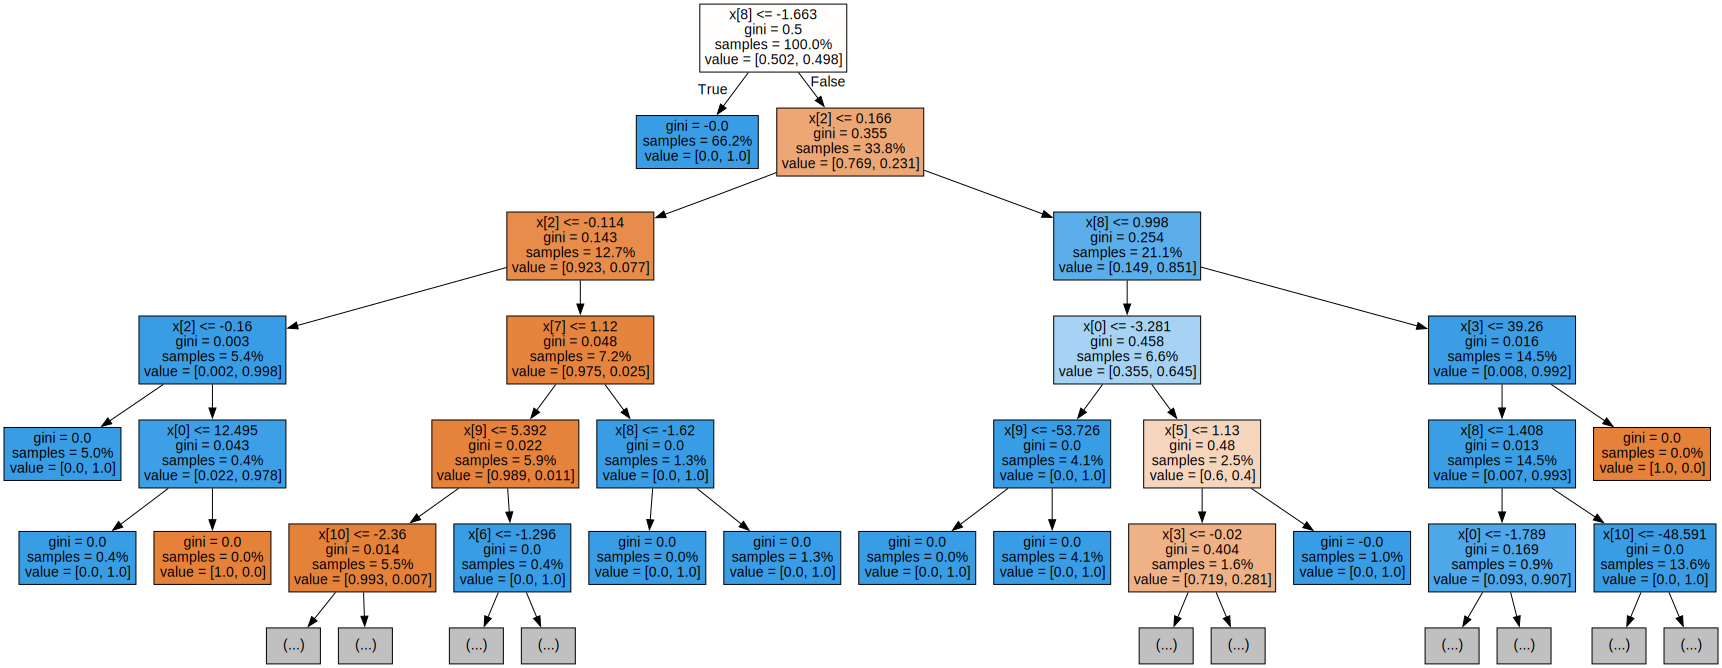

In [32]:
# Export the first three decision trees from the forest
features = np.genfromtxt('../data/medical_regular_data.csv', dtype='str', max_rows=1, delimiter=',')[:-1]
print(features)
for i in range(5):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               #feature_names=features,  
                               filled=True,  
                               max_depth=5, 
                               impurity=True, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [33]:
if DATASET == 'network_data':
    y_pred_network = y_pred
if DATASET == 'medical_data':
    y_pred_medical = y_pred
if False:
    y_pred_combined = np.logical_or(y_pred_medical, y_pred_network)
    accuracy = accuracy_score(test_Y, y_pred_combined)
    precision, recall, f1 = precision_score(test_Y, y_pred_combined), recall_score(test_Y, y_pred_combined), f1_score(test_Y, y_pred_combined)

    print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")